In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import os
import json
import addict
import numpy as np
import pandas as pd
import igraph as ig
import scanpy as sc
import scanpy.external as sce
from scipy.sparse import csr_matrix, isspmatrix

from datetime import datetime
time_start = datetime.now()

sc.logging.print_header()
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.4 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


In [4]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import utils as us
from src.utils import visualise as vs
%load_ext autoreload
%autoreload 2
warnings.filterwarnings("once")

## 1.3 Custom Plotting Functions

In [5]:
os.makedirs(config.PATHS.LOGS, exist_ok=True)
os.makedirs(config.PATHS.LOGS/'appendix', exist_ok=True)
state = addict.Dict({ 'PROTOCOL': config.PROTO })

us.erase_log()
us.log(json.encoder.JSONEncoder(indent='  ').encode(config.PROTO))

{
  "SEED": 42,
  "EXPERIMENT_ID": "SUBSET_1",
  "DESCRIPTION": "WO OPEN Dataset, WO BANOBO",
  "DATASETS": {
    "E-MATB": true,
    "MENDELEY": true,
    "OPEN": false
  },
  "SUBSET": {
    "APE_HUMAN_OVERLAP": true,
    "BANOBO": false,
    "TIMEPOINTS": [
      14,
      28,
      35,
      119,
      126
    ]
  },
  "PSEUDO_BULK": {
    "TYPE": "decoupler",
    "SIZE": 75,
    "REPS": 2
  },
  "CONTRAST": "",
  "QC": {
    "MIN_GENES": 500,
    "MAX_GENES": 5000,
    "MIN_COUNTS": 750,
    "MAX_COUNTS": 10000,
    "MT_PERCENTAGE": 5,
    "RB_PERCENTAGE": 35,
    "MIN_CELLS_PCT": 0.5
  }
}


In [6]:
datasets = list()
if config.PROTO.DATASETS['E-MATB']:
    datasets.append(sc.read(config.PATHS.CSV/'EMATB.h5ad'))
if config.PROTO.DATASETS['MENDELEY']:
    datasets.append(sc.read(config.PATHS.CSV/'MENDELEY.h5ad'))
if config.PROTO.DATASETS['OPEN']:
    datasets.append(sc.read(config.PATHS.CSV/'OPEN.h5ad'))

In [7]:
adata = us.merge_datasets(datasets)
adata.obs.head()

,timepoint,line,cluster,timepoint_mapped,batch,dataset
AAACCTGAGACCTAGG-4.d5_409b2_171212,d5,409b2,C8,5,b0,EMATB
AAACCTGAGTCCGTAT-4.d5_409b2_171212,d5,409b2,C5,5,b0,EMATB
AAACCTGGTATCTGCA-4.d5_409b2_171212,d5,409b2,C5,5,b0,EMATB
AAACCTGTCATAAAGG-4.d5_409b2_171212,d5,409b2,C8,5,b0,EMATB
AAACCTGTCGTTGCCT-4.d5_409b2_171212,d5,409b2,C7,5,b0,EMATB


### Whether to drop Bonobo & subset timepoints

In [8]:
if not config.PROTO.SUBSET.BONOBO:
    adata = adata[
        adata.obs.line.apply(lambda x: x.lower() not in config.BONOBO)]

adata = adata[
    adata.obs.timepoint_mapped.apply(
        lambda x: int(x) in config.PROTO.SUBSET.TIMEPOINTS)]

### Consider only overlap of Ape & Human genes

In [9]:
adata.obs['isHuman'] = adata.obs.line.apply(
    lambda x: x.lower() in config.HUMANS)

nonzero = adata.X[adata.obs['isHuman']].sum(0)
human_genes = adata.var[np.array(nonzero.tolist()[0]) != 0]

nonzero = adata.X[~adata.obs['isHuman']].sum(0)
ape_genes = adata.var[np.array(nonzero.tolist()[0]) != 0]

symdiff = ape_genes.index.symmetric_difference(human_genes.index).shape[0]
intersect = ape_genes.index.intersection(human_genes.index)

state['human_vs_apes_overlap'] = 1 - symdiff / (
    intersect.shape[0] + symdiff)
us.log(
    'The {:2.0f}% genes are overlaped bw Ape & Human in the data'.format(
        state['human_vs_apes_overlap'] * 100))

if config.PROTO.SUBSET.APE_HUMAN_OVERLAP:
    adata = adata[:, intersect]

/tmp/ipykernel_19631/1062825657.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['isHuman'] = adata.obs.line.apply(


The 96% genes are overlaped bw Ape & Human in the data


In [10]:
adata.obs['isESC'] = adata.obs.line.apply(
    lambda x: x.lower() in config.ESC)

nonzero = adata.X[(~adata.obs['isESC']) & adata.obs['isHuman']].sum(0)
induced_genes = adata.var[np.array(nonzero.tolist()[0]) != 0]

nonzero = adata.X[adata.obs['isESC']].sum(0)
ESC_genes = adata.var[np.array(nonzero.tolist()[0]) != 0]

symdiff = ESC_genes.index.symmetric_difference(
    induced_genes.index)
intersect = ESC_genes.index.intersection(induced_genes.index)

state['induced_vs_ESC_overlap'] = 1 - symdiff.shape[0] / (
    intersect.shape[0] + symdiff.shape[0])
us.log(
    'The {:2.0f}% genes are overlaped bw ESCs & Induced in the data'.format(
        state['induced_vs_ESC_overlap'] * 100))

if config.PROTO.SUBSET.APE_HUMAN_OVERLAP:
    adata = adata[:, intersect]

/tmp/ipykernel_19631/1268173437.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['isESC'] = adata.obs.line.apply(


The 99% genes are overlaped bw ESCs & Induced in the data


In [11]:
symdiff

Index(['AC004837.5', 'AC005477.1', 'AC007906.1', 'AC024592.12', 'AC060834.3',
       'AC108868.6', 'AC136616.1', 'ACOT4', 'ACOT6', 'ACTL10',
       ...
       'TNFRSF10A', 'TTTY14', 'UCP1', 'XCL2', 'ZC3HAV1L', 'ZFP3', 'ZNF619',
       'ZNF732', 'ZNF835', 'bP-21264C1.2'],
      dtype='object', length=121)

In [12]:
us.log(adata.shape)
us.log('isspmatrix: {}'.format(isspmatrix(adata.X)))


us.log('Loaded Filtered AnnData object: number of cells {}'.format(adata.n_obs))
us.log('Loaded Filtered AnnData object: number of genes {}'.format(adata.n_vars) )
us.log('Available metadata for each cell:  {}'.format(adata.obs.columns))

(43829, 16738)
isspmatrix: True
Loaded Filtered AnnData object: number of cells 43829
Loaded Filtered AnnData object: number of genes 16738
Available metadata for each cell:  Index(['timepoint', 'line', 'cluster', 'timepoint_mapped', 'batch', 'dataset',
       'isHuman', 'isESC'],
      dtype='object')


# Cell metadata

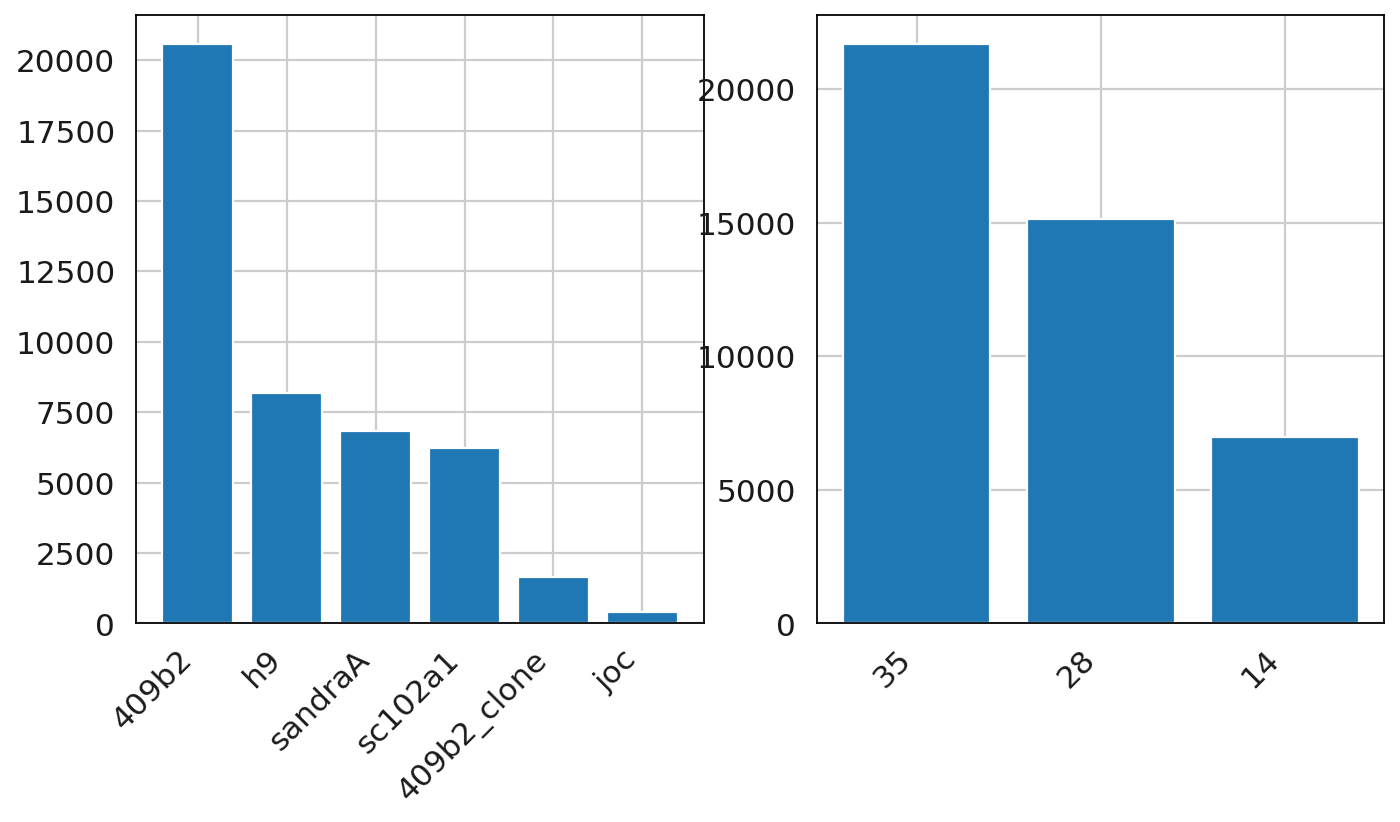

In [13]:
### Gestation week
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
x = adata.obs['line'].value_counts()
vs.plot_bar(axs[0], x)
x = adata.obs['timepoint_mapped'].value_counts()
vs.plot_bar(axs[1], x)
fig.savefig(config.PATHS.APPENDIX/'linetimebar')
fig.show()
us.log('', 'linetimebar')

In [14]:
# adata.obs['clusters'].value_counts().plot.barh()
# adata.obs['clusters'].value_counts()

# Top-expressed genes

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:02)


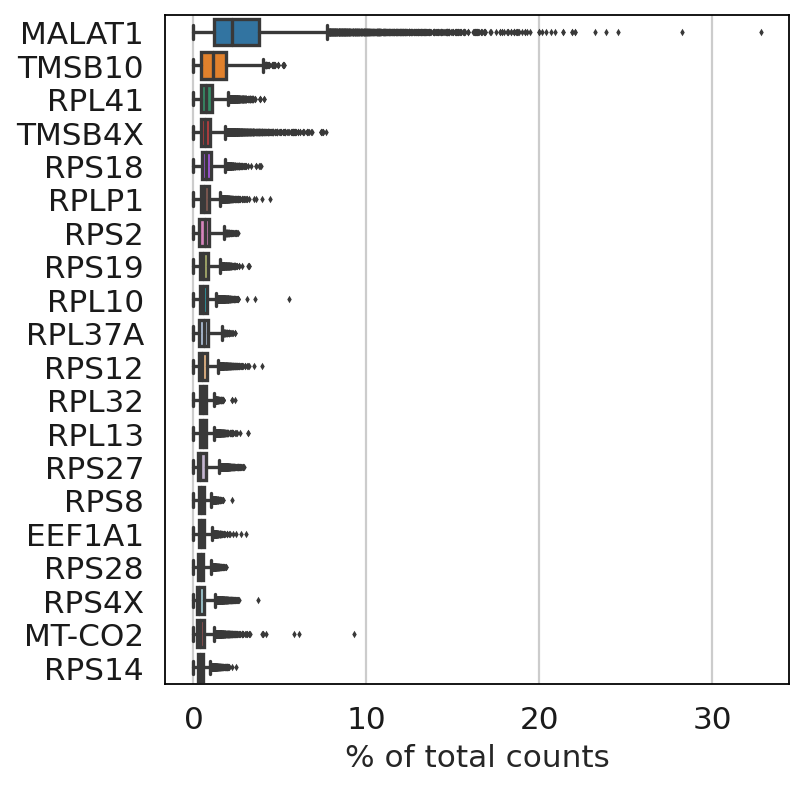

In [15]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Quality Check

## Gene Filtering

In [16]:
# Filtering genes on minimum cells: 0.5%
state['MIN_CELLS'] = np.rint(
    (adata.n_obs * config.PROTO.QC.MIN_CELLS_PCT) / 100)
state['MIN_CELLS']

219.0

## Identify Mitocondrial and Ribosomal genes

In [17]:
#Find mito and ribo genes
mito_genes = adata.var_names.str.startswith('MT-')    
ribo_genes = adata.var_names.str.contains('^RPS|^RPL')

adata.var['mito'] = adata.var_names.str.startswith('MT-')    
adata.var['ribo']= adata.var_names.str.contains('^RPS|^RPL')

adata.var_names[ribo_genes]

Index(['RPL22', 'RPL11', 'RPS6KA1', 'RPS8', 'RPL5', 'RPS27', 'RPS6KC1', 'RPS7',
       'RPS27A', 'RPL31', 'RPL37A', 'RPL32', 'RPL15', 'RPSA', 'RPL14', 'RPL29',
       'RPL24', 'RPL22L1', 'RPL39L', 'RPL35A', 'RPL9', 'RPL34-AS1', 'RPL34',
       'RPS3A', 'RPL37', 'RPS23', 'RPS14', 'RPL26L1', 'RPS18', 'RPS10',
       'RPL10A', 'RPL7L1', 'RPS12', 'RPS6KA2', 'RPS6KA3', 'RPS4X', 'RPS6KA6',
       'RPL36A', 'RPL39', 'RPL10', 'RPS20', 'RPL7', 'RPL30', 'RPL8', 'RPS6',
       'RPL35', 'RPL12', 'RPL7A', 'RPLP2', 'RPL27A', 'RPS13', 'RPS6KA4',
       'RPS6KB2', 'RPS3', 'RPS25', 'RPS24', 'RPS26', 'RPL41', 'RPL6', 'RPLP0',
       'RPL21', 'RPL10L', 'RPS29', 'RPL36AL', 'RPS6KL1', 'RPS6KA5', 'RPS27L',
       'RPL4', 'RPLP1', 'RPS17', 'RPS2', 'RPS15A', 'RPL13', 'RPL26', 'RPL23A',
       'RPL23', 'RPL19', 'RPL27', 'RPS6KB1', 'RPL38', 'RPL17-C18orf32',
       'RPL17', 'RPS21', 'RPS15', 'RPL36', 'RPS28', 'RPL18A', 'RPS16', 'RPS19',
       'RPL18', 'RPL13A', 'RPS11', 'RPS9', 'RPL28', 'RPS5', 'RPL3',
       

## Automated QC metrics

In [18]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mito','ribo'], inplace=True,
    log1p=False, percent_top=None)

adata.obs.head()

,timepoint,line,cluster,timepoint_mapped,batch,dataset,isHuman,isESC,n_genes_by_counts,total_counts,total_counts_mito,pct_counts_mito,total_counts_ribo,pct_counts_ribo
AAACCTGAGTACTTGC-9.w2_409b2_171212,w2,409b2,C5,14,b1,EMATB,True,False,2431,7029,170,2.418552,1754,24.953763
AAACCTGCACGGCCAT-9.w2_409b2_171212,w2,409b2,C7,14,b1,EMATB,True,False,2570,7490,174,2.323097,1743,23.271028
AAACCTGCAGTATCTG-9.w2_409b2_171212,w2,409b2,C5,14,b1,EMATB,True,False,2437,6411,226,3.525191,1417,22.102636
AAACCTGGTTTAAGCC-9.w2_409b2_171212,w2,409b2,C7,14,b1,EMATB,True,False,2749,8042,334,4.153196,1858,23.103706
AAACGGGCACGCCAGT-9.w2_409b2_171212,w2,409b2,C5,14,b1,EMATB,True,False,2128,5274,144,2.730375,1199,22.734168


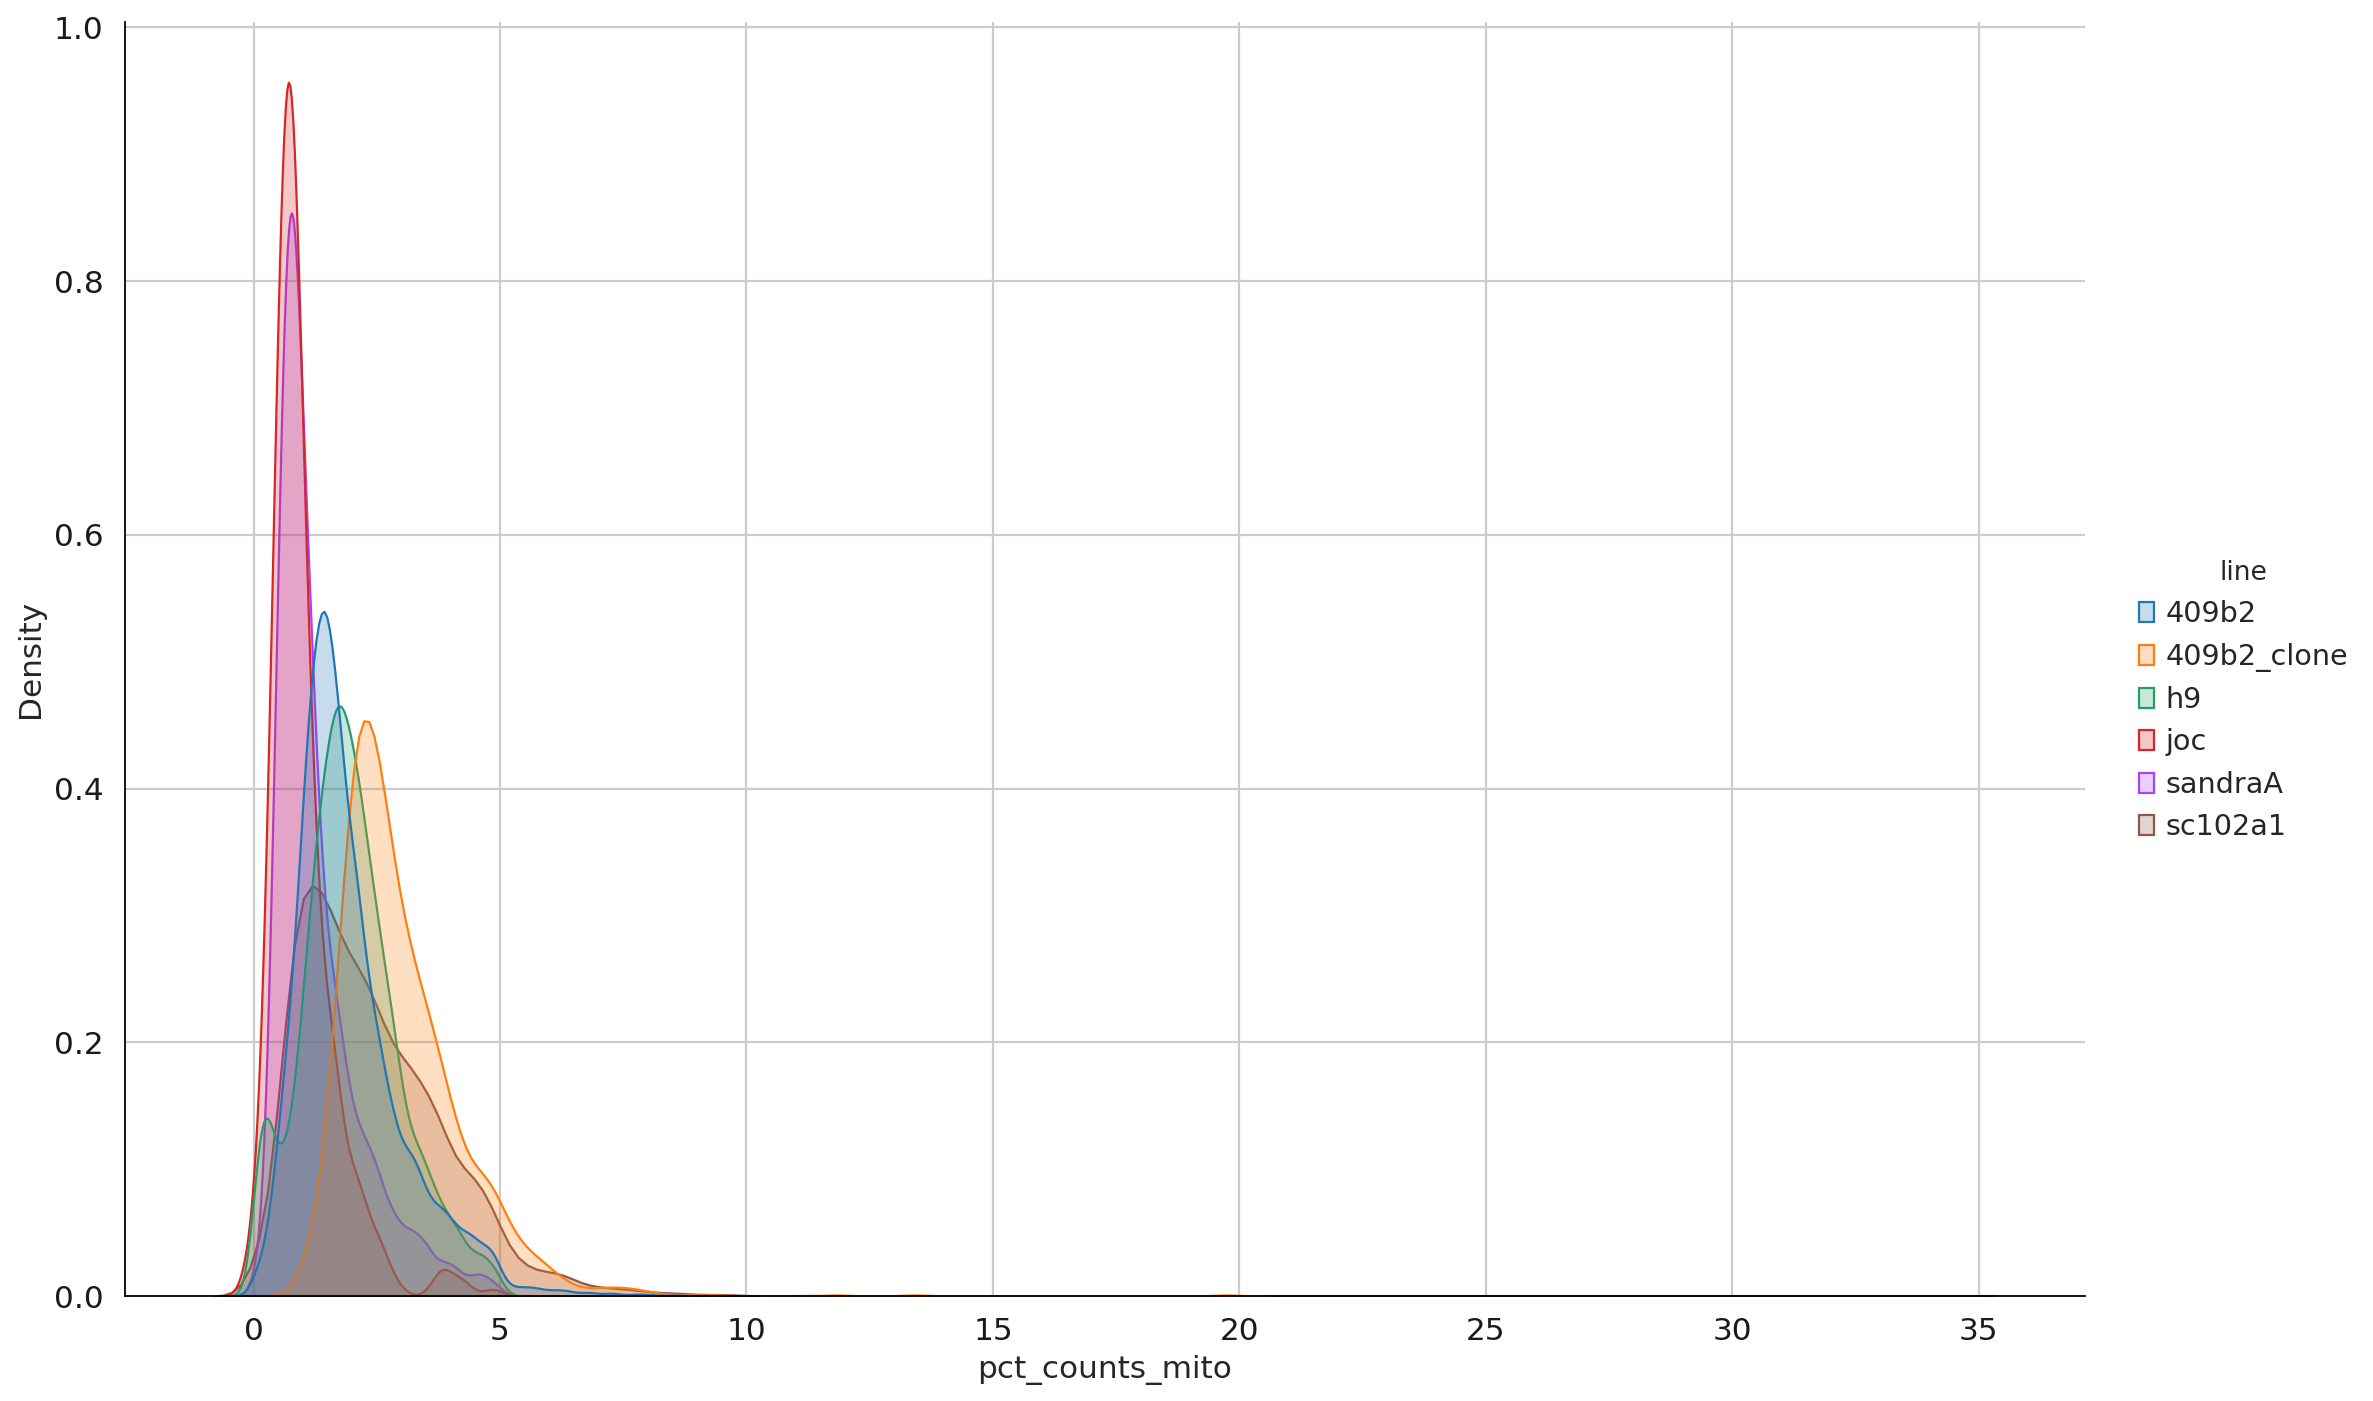

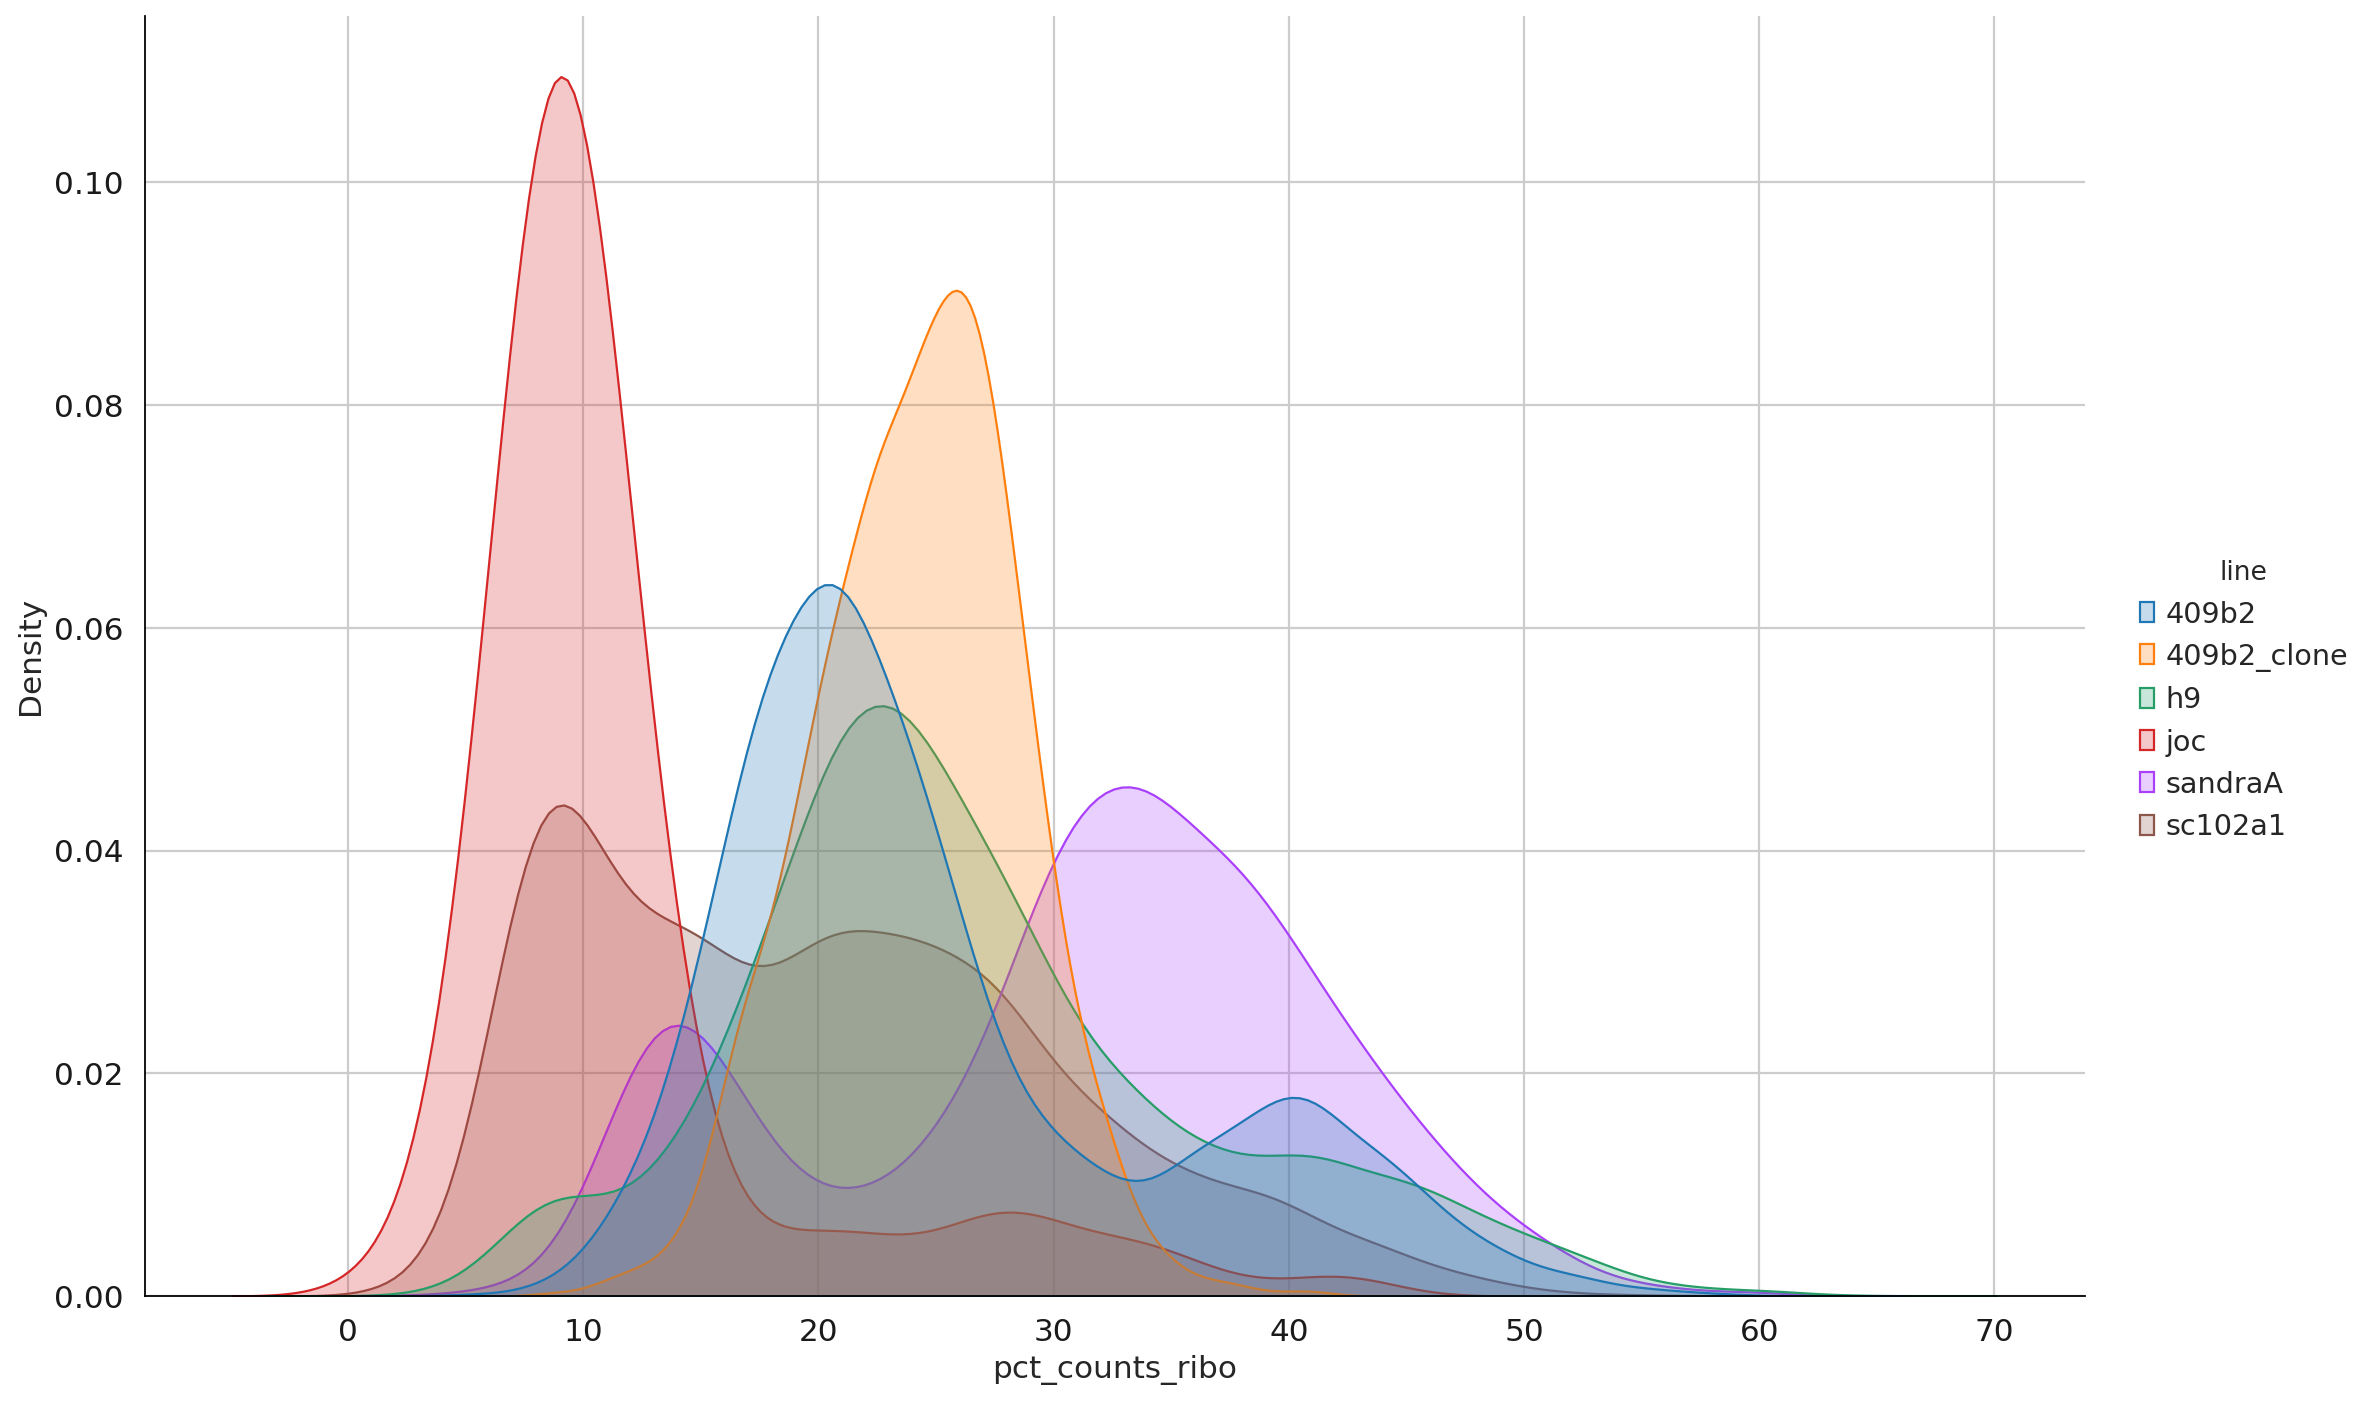

In [19]:
sns.displot(
    adata.obs, x="pct_counts_mito",
    hue="line", kind="kde", fill=True,
    # stat="density", 
    common_norm=False,
    height=9, aspect=1.5
)
sns.displot(
    adata.obs, x="pct_counts_ribo",
    hue="line", kind="kde", fill=True,
    # stat="density", 
    common_norm=False,
    height=9, aspect=1.5
)

In [20]:
# sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed=True)
# sc.pp.log1p(adata)
# tsne = sc.tl.tsne(adata)

In [21]:
# sns.set(rc={'figure.figsize':(10,10)})
# sns.scatterplot(
#     data=adata.obs#[adata.obs.line == 'sandraA'],
#     x="tSNE_1", y="tSNE_2", hue="pct_counts_ribo",
#     hue_norm=(0, 60)
#     # legend=None
# )

## Inspect quality-related parameters

In [22]:
us.log('Mitochondrial genes')
us.log(np.quantile(adata.obs['pct_counts_mito'], np.arange(0, 1.1, 0.1))) 

Mitochondrial genes
[ 0.          0.70244921  0.98710446  1.22562674  1.45492475  1.69154229
  1.9636058   2.29007634  2.75337838  3.54569077 34.53427065]


In [23]:
us.log('Ribosomal Protein genes')
us.log(np.quantile(adata.obs['pct_counts_ribo'], np.arange(0, 1.1, 0.1)))

Ribosomal Protein genes
[ 1.47601476 13.64154741 17.09659889 19.51166821 21.51968941 23.69873817
 26.24517955 29.80791917 35.02994012 40.82365364 65.13915547]


In [24]:
us.log('Total number of counts for each cell')
us.log(np.quantile(adata.obs['total_counts'], np.arange(0, 1.1, 0.1)))

Total number of counts for each cell
[  594.   2495.   3267.   4048.   4881.   5814.   6871.   8308.6 10377.8
 14193.2 57189. ]


In [25]:
us.log('Number of genes detected in each cell')
us.log(np.quantile(adata.obs['n_genes_by_counts'], np.arange(0, 1.1, 0.1)))

Number of genes detected in each cell
[ 495.  1135.  1412.  1671.  1907.2 2164.  2447.  2783.  3221.  3917.
 6638. ]


## Visualization
Violin plots: linear values

In [26]:
warnings.filterwarnings("ignore")

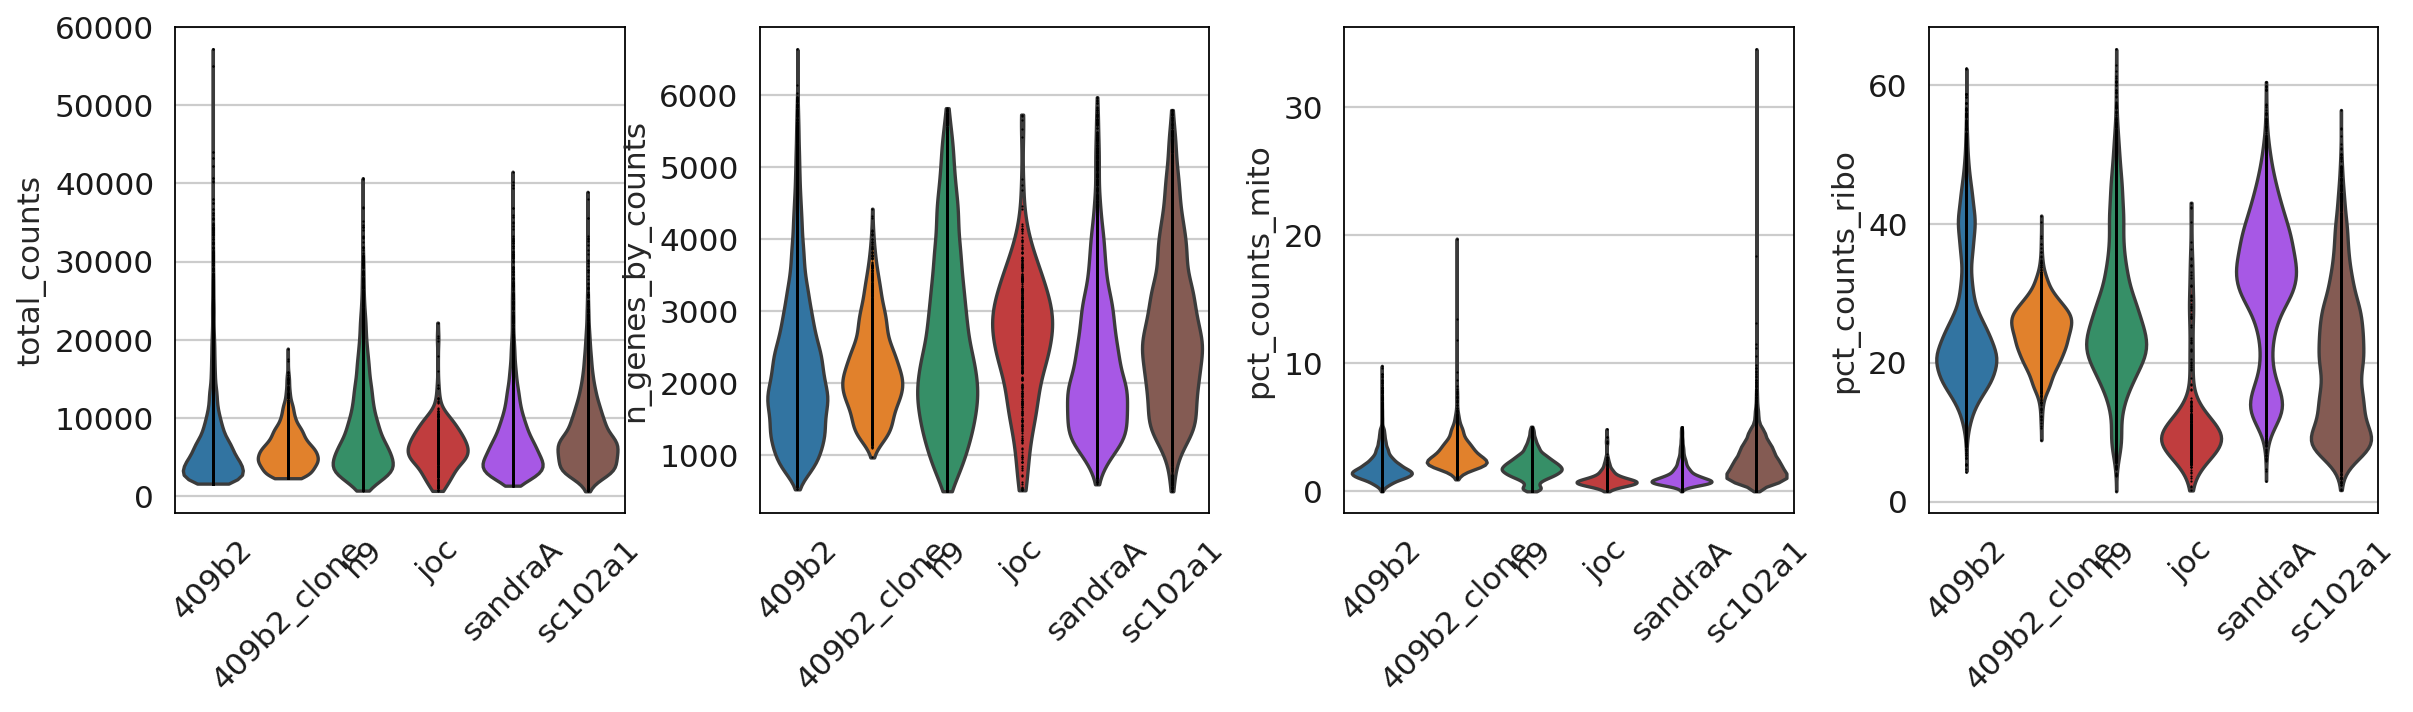

In [27]:
sc.pl.violin(adata, keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mito', 'pct_counts_ribo'],
             jitter=False, multi_panel=True, groupby='line', rotation=45)

Violin plots: log values

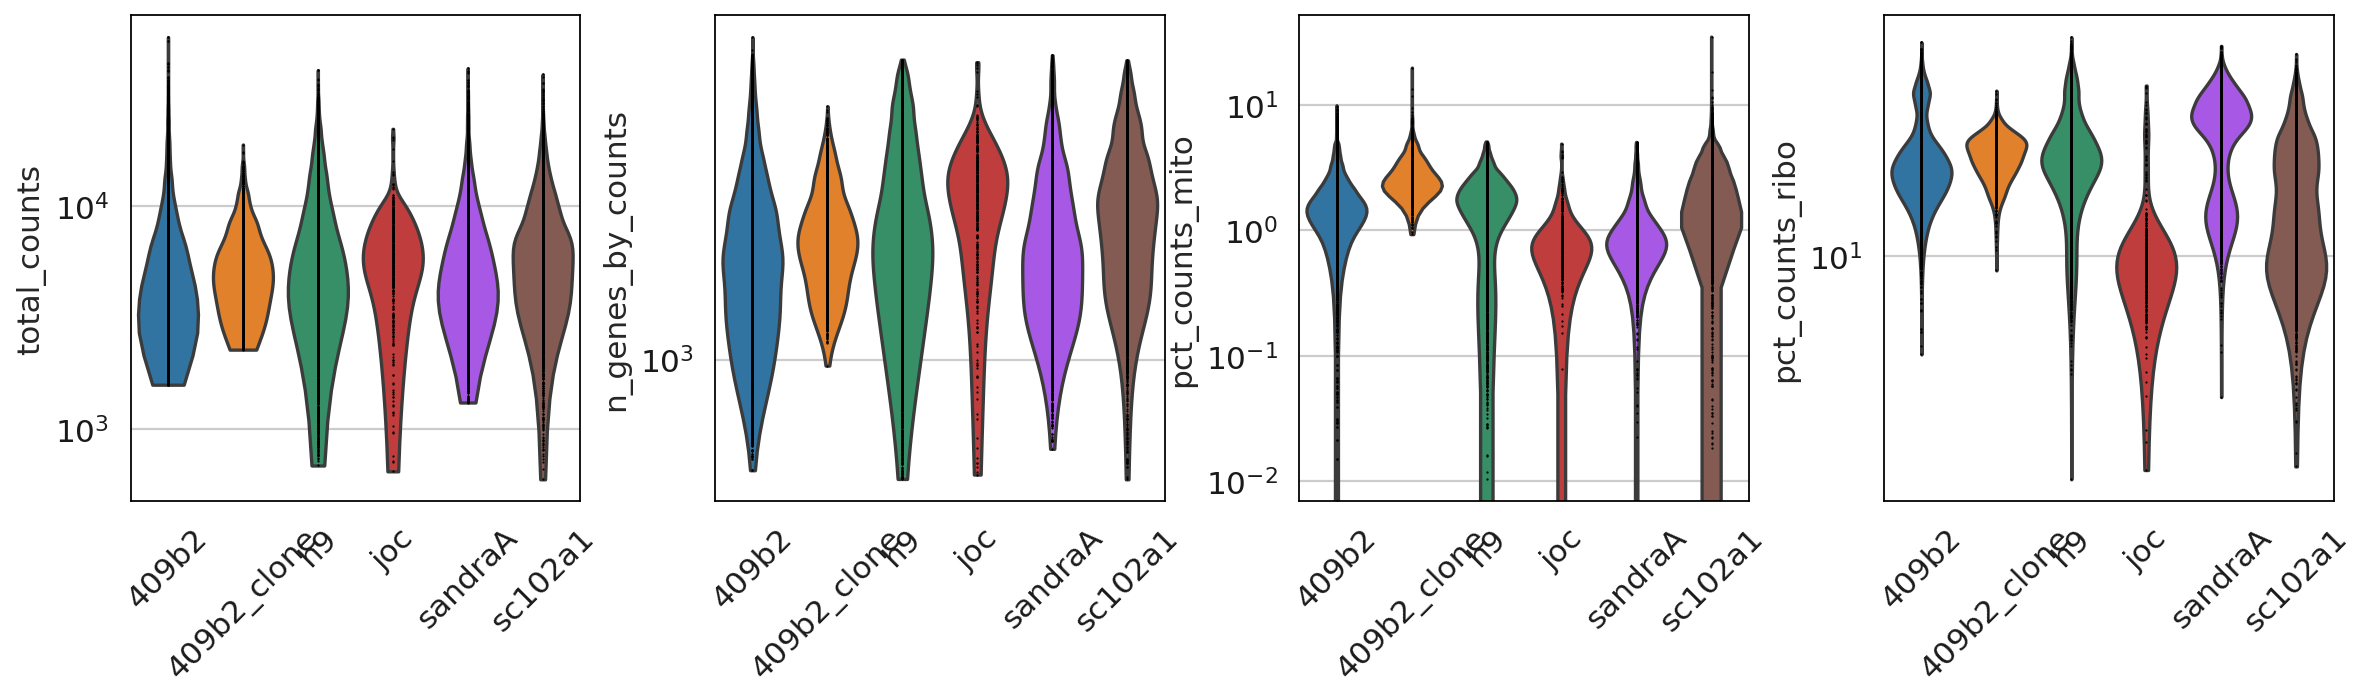

In [28]:
sc.pl.violin(adata, keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mito', 'pct_counts_ribo'],
             jitter=False, multi_panel=True, log=True, groupby='line', rotation=45)

Density plots  

Single Plots

Thresholds applied


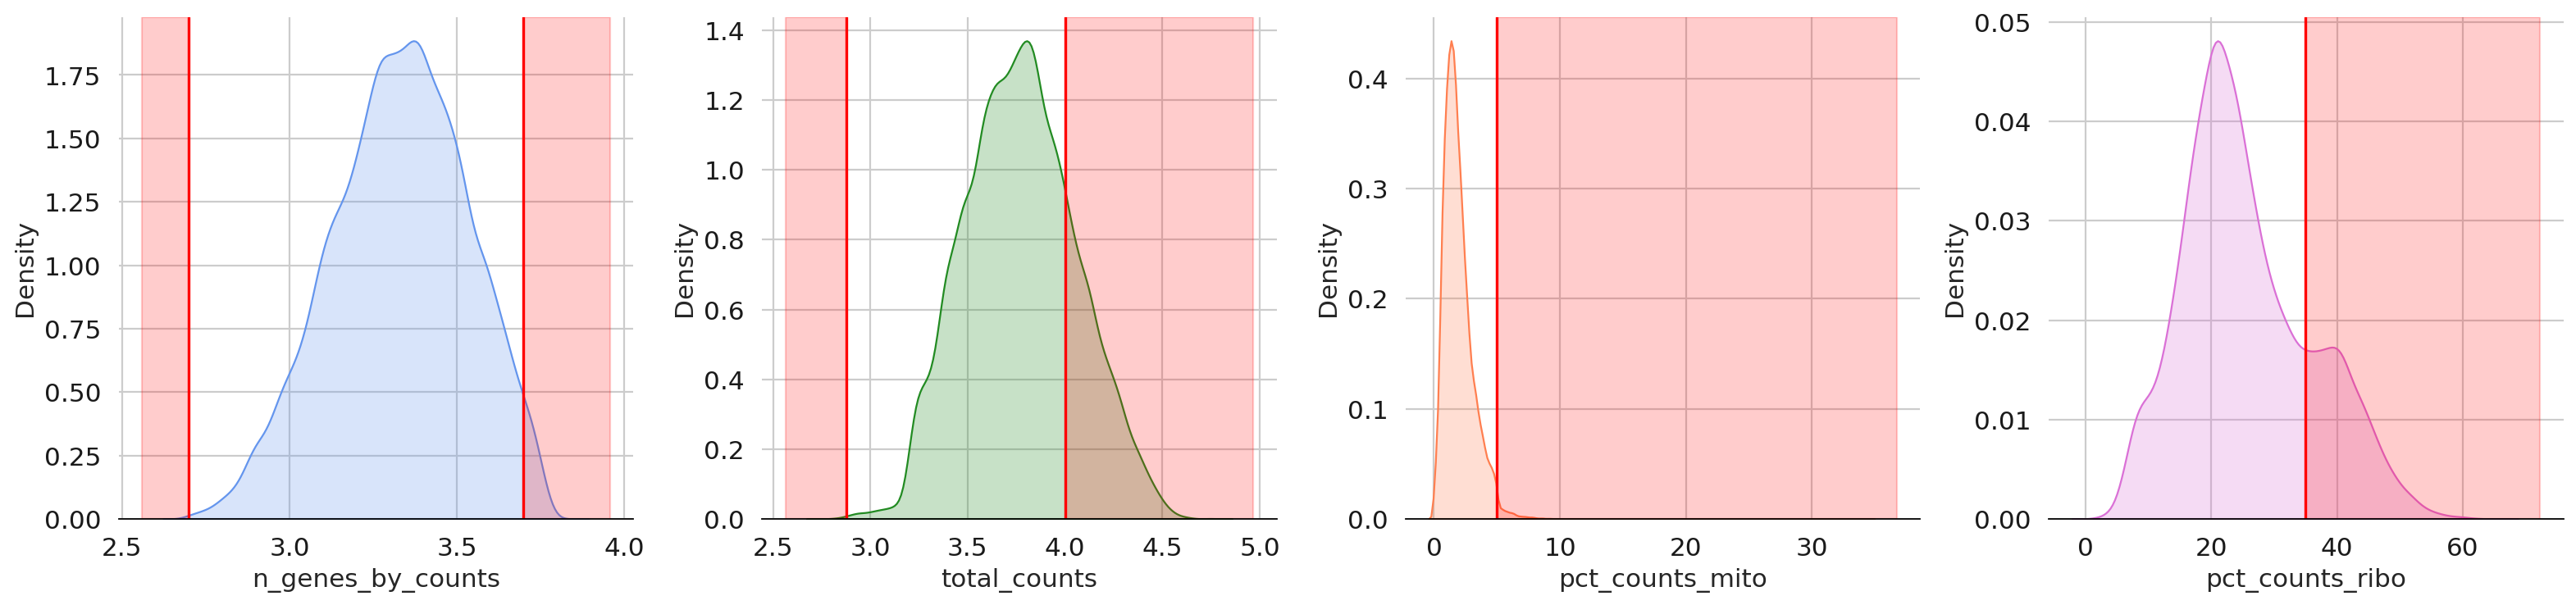

In [29]:
vs.densityQCs(adata)
plt.savefig(config.PATHS.APPENDIX/'QC_thresholds')
us.log('Thresholds applied', 'QC_thresholds')

Double Plots

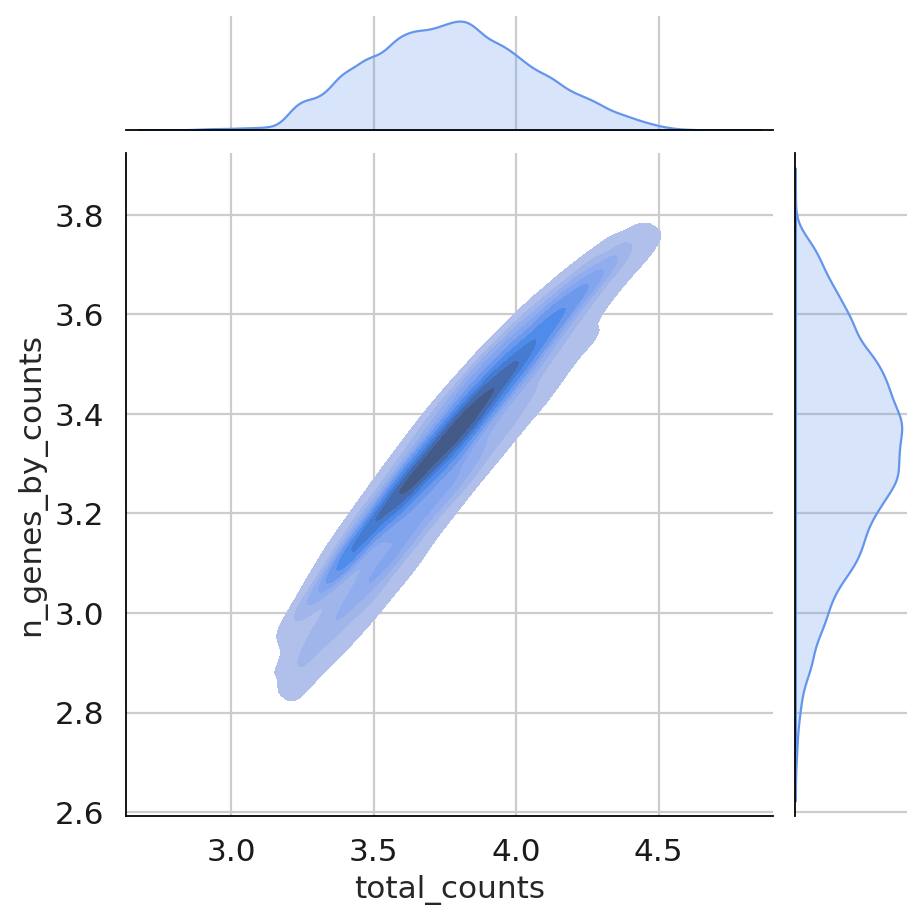

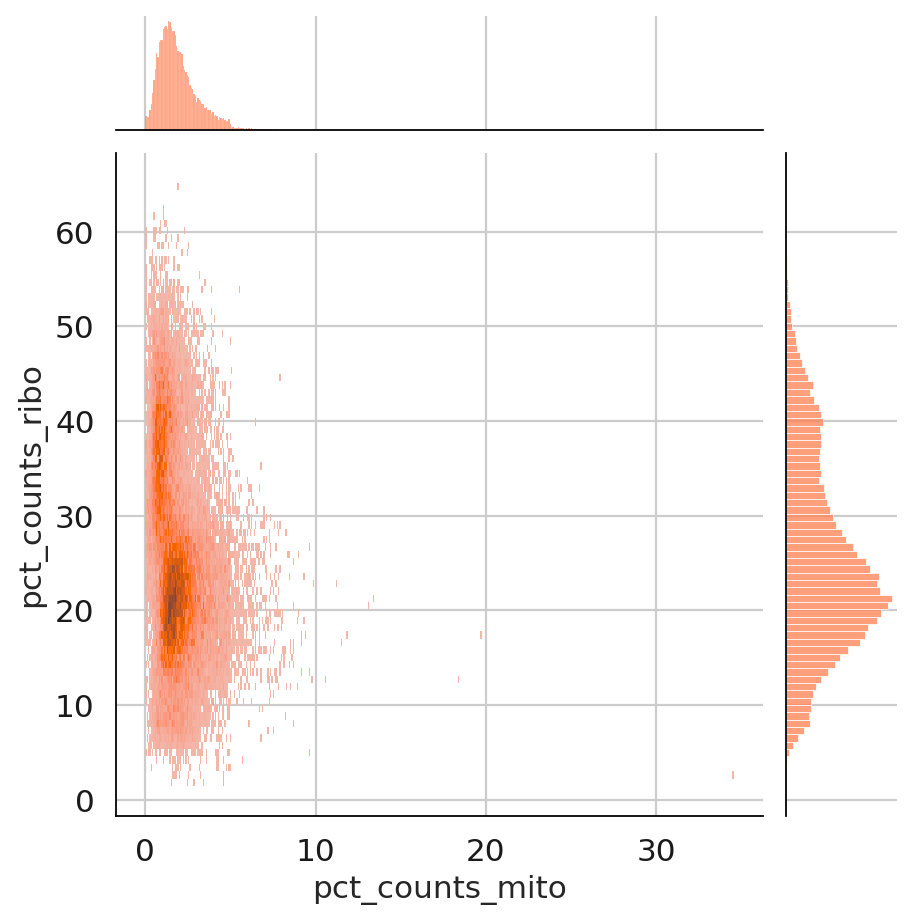

In [30]:
sns.jointplot(x=np.log10(adata.obs['total_counts']), 
              y=np.log10(adata.obs['n_genes_by_counts']), 
              kind="kde", color="cornflowerblue", fill=True)

sns.jointplot(x=adata.obs['pct_counts_mito'], 
              y=adata.obs['pct_counts_ribo'], 
              kind="hist", color="coral")

In [31]:
import scrublet as scr
scrub = scr.Scrublet(adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata.obs['QC_doublets'] = doublet_scores

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 29.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.5%
Elapsed time: 79.8 seconds


In [32]:
# sns.scatterplot(
#     data=adata.obs[adata.obs.line == 'sandraA'], x="tSNE_1", y="tSNE_2", hue="QC_doublets",
#     hue_norm=(0, 1), legend=None
# )

In [33]:
adata = adata[~predicted_doublets]
us.log('{} predicted doublets removed'.format(len(predicted_doublets)))

43829 predicted doublets removed


# Filtering

In [34]:
message = '\n'.join([
    'The selected filtering parameters are: \n Minimum cells: {}'.format(
        state.MIN_CELLS), 
    ' Minimum counts: {}'.format(config.PROTO.QC.MIN_COUNTS), 
    ' Maximum counts: {}'.format(config.PROTO.QC.MAX_COUNTS),
    ' Minimum genes: {}'.format(config.PROTO.QC.MIN_GENES), 
    ' Maximum genes: {}'.format(config.PROTO.QC.MAX_GENES),
    ' Mitocondia: {}%'.format(config.PROTO.QC.MT_PERCENTAGE),
    ' Ribosomal: {}%'.format(config.PROTO.QC.RB_PERCENTAGE)])
us.log(message)

The selected filtering parameters are: 
 Minimum cells: 219.0
 Minimum counts: 750
 Maximum counts: 10000
 Minimum genes: 500
 Maximum genes: 5000
 Mitocondia: 5%
 Ribosomal: 35%


## Filtering Cells

In [35]:
# Detected Genes
sc.pp.filter_cells(adata, min_genes=config.PROTO.QC.MIN_GENES)
us.log('After filtering on min detected genes:number of cells: {}'.format(adata.n_obs))

# UMI Counts
sc.pp.filter_cells(adata, min_counts = config.PROTO.QC.MIN_COUNTS)
us.log('After filtering on min UMI counts:number of cells: {}'.format(adata.n_obs))

# Mitochondrial RNA

#adata.obs[adata.obs['percent_mito'] > 0.05]  
adata = adata[adata.obs['pct_counts_mito'] < config.PROTO.QC.MT_PERCENTAGE, :]
us.log('After filtering on mitochondrial RNA: number of cells: {}'.format(adata.n_obs))

# Ribosomal RNA

#adata = adata[adata.obs['percent_ribo'] < 0.35, :]
adata = adata[adata.obs['pct_counts_ribo'] < config.PROTO.QC.RB_PERCENTAGE, :]
us.log('After filtering on ribosomal protein RNA: number of cells: {}'.format(adata.n_obs))


filtered out 4 cells that have less than 500 genes expressed
After filtering on min detected genes:number of cells: 43764
filtered out 9 cells that have less than 750 counts
After filtering on min UMI counts:number of cells: 43755
After filtering on mitochondrial RNA: number of cells: 43081
After filtering on ribosomal protein RNA: number of cells: 34314


## Filtering genes

In [36]:
us.log('Before gene filtering: number of genes: {}'.format(adata.n_vars))
us.log('Before gene filtering: number of cells: {}'.format(adata.n_obs))

us.log(state.MIN_CELLS) # Filtering genes on minimum cells: 1%
sc.pp.filter_genes(adata, min_cells=state.MIN_CELLS)

us.log('After gene filtering: number of genes: {}'.format(adata.n_vars))
us.log('After filtering: number of cells: {}'.format(adata.n_obs))

Before gene filtering: number of genes: 16738
Before gene filtering: number of cells: 34314
219.0
filtered out 1955 genes that are detected in less than 219.0 cells
After gene filtering: number of genes: 14783
After filtering: number of cells: 34314


## Numbers after filtering

After applied filtering: number of cells: 34314
After applied filtering: number of genes: 14783


<Axes: xlabel='line'>

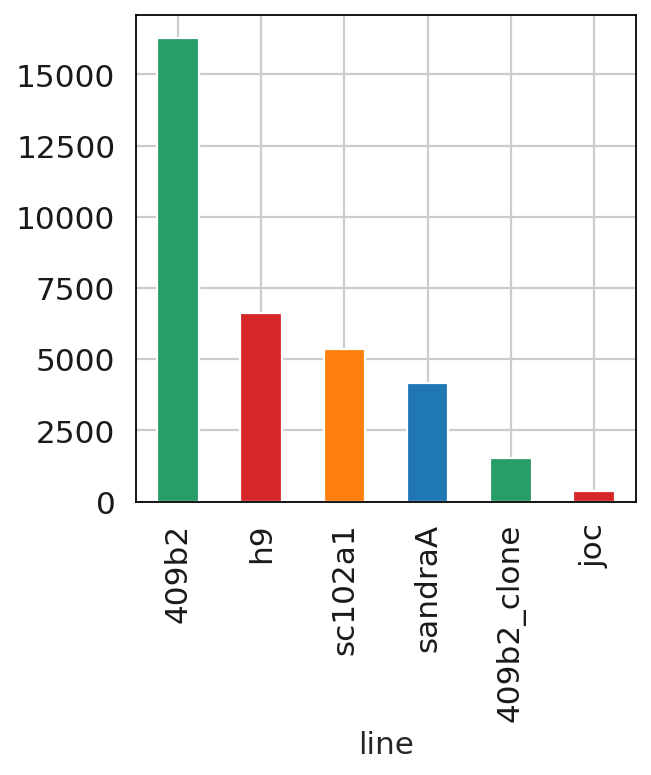

In [37]:
us.log('After applied filtering: number of cells: {}'.format(adata.n_obs))
us.log('After applied filtering: number of genes: {}'.format(adata.n_vars))

adata.obs['line'].value_counts().plot.bar(color=['#279e68', '#d62728', '#ff7f0e', '#1f77b4'])

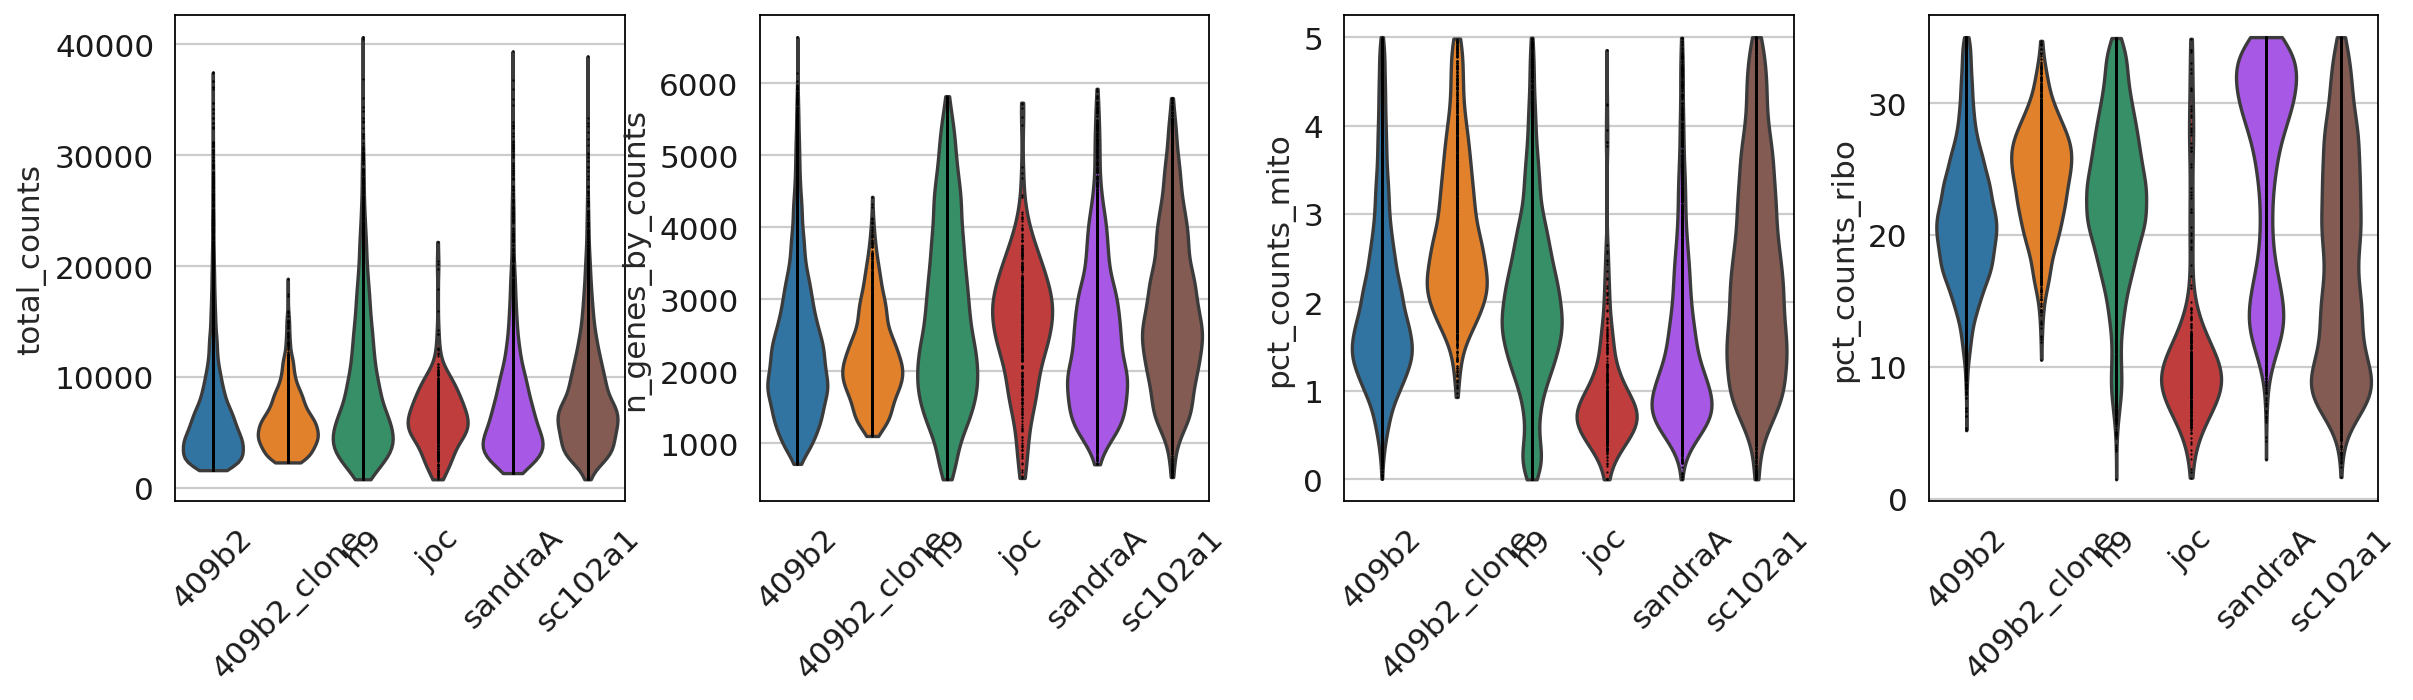

In [38]:
sc.pl.violin(
    adata, keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mito', 'pct_counts_ribo'],
    groupby='line', jitter=False, multi_panel=True, rotation=45)


# Save

In [39]:
# Check that adata.X is stored as sparse if not convert
if (isspmatrix(adata.X) == False):
    adata.X = csr_matrix(adata.X)
    us.log("Converted adata.X to sparse")

In [40]:
adata.obs.cluster = adata.obs.cluster.astype(str)
adata.write(config.PATHS.LOGS/'QC.h5ad')
us.log(datetime.now() - time_start)

0:02:35.661879
